<a href="https://colab.research.google.com/github/clemgi0/movie-analyser_deep-learning-proyecto/blob/main/03_arquitectura_de_linea_de_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Analyser | Deep Learning Final Project

In this serie of notebook, we will follow my avances for this project. Let's begin by defining it. Basically, what I want to achieve is to create a deep learning AI model using Keras and Tensorflow that could predict the success of a movie through it's resume, and some other possible input datas like the name of the movie, it's director or it's genre.

### DATASETS
https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

Features of the first dataset :

Here are it's features:

0 Poster_Link - Link of the poster that imdb using

1 Series_Title - Name of the movie

2 Released_Year - Year at which that movie released

3 Certificate - Certificate earned by that movie

4 Runtime - Total runtime of the movie

5 Genre - Genre of the movie

6 IMDB_Rating - Rating of the movie at IMDB site

7 Overview - mini story/ summary

8 Meta_score - Score earned by the movie

9 Director - Name of the Director

10, 11, 12, 13 Star1,Star2,Star3,Star4 - Name of the Stars

14 No_of_votes - Total number of votes

15 Gross - Money earned by that movie



https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset

Features of the second dataset :

0 Filmtv_id - Movie id

1 Title - Name of the movie

2 Year - Movie year of release

3 Genre - Movie genre

4 Duration - Movie duration (in min)

5 Country - Countries where the movie was filmed

6 Directors - Name of movie directors

7 Actors - Name of movie actors

8 Avg_vote - Average rating (by critics and public)

9 Critics_vote - Average vote of the critics

10 Public_vote - Average vote of the public

11 Total_vote - Total votes expressed by critics and public

12 Overview - Movie description

13 Notes - Movie notes

14 Humor - Movie humor score given by filmtv

15 Rythm - Movie rythm score given by filmtv

16 Tension - Movie tension score given by filmtv

17 Erotism - Movie erotism score given by filmtv

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub
import os
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

## Base architecture
In this thirs notebook, we will focus on realising a basic architecture to test out our datas. Then, we will try to implement a more complicated model architecture to intent to get the best results possible.

### Data preparation

**Here we select the dataset that we want to use (run two times so it shows "Using Colab cache...).**

In [175]:
path = kagglehub.dataset_download("harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows")
dataset = "IMDB"

Using Colab cache for faster access to the 'imdb-dataset-of-top-1000-movies-and-tv-shows' dataset.


In [4]:
path = kagglehub.dataset_download("stefanoleone992/filmtv-movies-dataset")
dataset = "FilmTV"

Using Colab cache for faster access to the 'filmtv-movies-dataset' dataset.


Here we import the datas we want and shuffle them for the reason we saw on the first notebook. We also withdraw the features that interests us.

In [5]:
files_in_path = os.listdir(path)
csv_files = [f for f in files_in_path if f.endswith('.csv')]

if csv_files:
    data_file = os.path.join(path, csv_files[0])
    df = pd.read_csv(data_file)

    df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the datas to avoid linear IMDB rating

    data = df.to_numpy()
    if dataset == "IMDB":
      data = data[:, [1, 5, 7, 9, 2, 6, 8]] # Title / Genre / Overview / Director / Average score / IMDB rating / meta-score
    else:
      data = data[:, [1, 3, 12, 6, 8]] # Title / Genre / Overview / Director / Average votes

    print("Data shape:", data[:3,:])
else:
    print("No CSV files found in the specified path. Please specify which file to load if it's not a CSV or has a different extension.")

Data shape: [['Svadba' 'Comedy'
  'Mishka and Tania, friends since school, are getting married. But something is wrong because the girl leaves for Moscow and disappears for a few years. Having vanished the dreams of becoming a model, she decides to return to the country to marry the good Mishka, muscular and solid worker with a clean face, still in love with her. At this point the film tells about the wedding preparations, the ceremony, the dramas and the trafficking that goes through it.'
  'Pavel Lungin' 7.0]
 ['The Phantom of Crestwood' 'Thriller'
  'Pushed by the beautiful Jenny Wren, banker Priam Andes throws a party at Crestwood, his summer residence. The girl asks Priam to also invite three wealthy men whom she intends to pluck, but her plans will be unexpectedly upset by an inexplicable death ...'
  'J. Walter Ruben' 6.5]
 ['Ragazzi della marina' 'War'
  'The cruiser "Raimondo Montecuccoli" leaves Livorno with the cadets of the Naval Academy. Among them, three sailors are worri

Here, we prepocess the datas as we did it in the second notebook by cleaning, shortening, tokenizing and normalizing them (takes approximately 1min for FilmTV dataset).

In [6]:
# Remove the rows containing nan values
df2 = pd.DataFrame(data)
df2 = df2.replace("nan", np.nan)   # if "nan" is a chain, we delete the row
df2 = df2.dropna()
data_clean = df2.to_numpy()
data_clean = data_clean[::6,:] # to reduce waiting time for model tuning


# Set variables
if dataset == "IMDB":
  ov_max_features = 5000
  ti_max_features = 1000
  ge_max_features = 23
else:
  ov_max_features = 6000
  ti_max_features = 2000
  ge_max_features = 30


# Downloading the english stopwords dictionnary and creating the remove_stowords function
nltk.download('punkt_tab')
nltk.download('stopwords')
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_all = stopwords_en
stopwords_all += nltk.corpus.stopwords.words('spanish')
stopwords_all += nltk.corpus.stopwords.words('french')
stopwords_all += nltk.corpus.stopwords.words('italian')
stopwords_all += nltk.corpus.stopwords.words('german')
stopwords_all = set(stopwords_all)

def remove_stopwords(text_list, language): # For the Overview since they are only in English
    cleaned_texts = []
    for text in text_list:
      if language == "english":
        tokens = [word.lower() for word in nltk.word_tokenize(text) if word.lower() not in stopwords_en]
      else:
        tokens = [word.lower() for word in nltk.word_tokenize(text) if word.lower() not in stopwords_all]
      cleaned_texts.append(' '.join(tokens))
    return cleaned_texts


# Tokenize Overview
data_clean[:,2] = remove_stopwords(data_clean[:,2], "english")
ov_tokenizer = Tokenizer(num_words=ov_max_features, split=' ')
ov_tokenizer.fit_on_texts(data_clean[:,2])
ov_tokenizer.word_index.update({'<pad>': 0})
ov_tokenized = ov_tokenizer.texts_to_sequences(data_clean[:,2])


# Tokenize Title
data_clean[:,0] = remove_stopwords(data_clean[:,0], "all")
ti_tokenizer = Tokenizer(num_words=ti_max_features, oov_token="<UNK>")
ti_tokenizer.fit_on_texts(data_clean[:,0])
ti_tokenized = ti_tokenizer.texts_to_sequences(data_clean[:,0])


# Labelize Director
directors_raw = data_clean[:, 3]
le_director = LabelEncoder()
di_labelized = le_director.fit_transform(directors_raw)


# Tokenize Genre
genres_split = [g.lower().split(", ") for g in data_clean[:,1]]
ge_tokenizer = Tokenizer(num_words=ge_max_features, oov_token="<UNK>")
ge_tokenizer.fit_on_texts([" ".join(g) for g in genres_split])
ge_tokenized = ge_tokenizer.texts_to_sequences([" ".join(g) for g in genres_split])


# Taking average and normalization of the scores
if dataset == "IMDB":
  data_clean[:,4] = (data_clean[:,5] + data_clean[:,6] / 10.0) / 2.0
sc_normalized = data_clean[:,4] / 10.0


# Padding the tokenized features
ov_max_len = max(len(x) for x in ov_tokenized)
ti_max_len = max(len(x) for x in ti_tokenized)
ge_max_len = max(len(x) for x in ge_tokenized)

ov_padded = pad_sequences(ov_tokenized, maxlen=ov_max_len)
ti_padded = pad_sequences(ti_tokenized, maxlen=ti_max_len)
ge_padded = pad_sequences(ge_tokenized, maxlen=ge_max_len)


# Splitting the datas
nb_train_data = int(0.8*len(data_clean[:,0]))

x_train_overview = ov_padded[:nb_train_data,:]
x_train_title = ti_padded[:nb_train_data,:]
x_train_director = di_labelized[:nb_train_data]
x_train_genre = ge_padded[:nb_train_data,:]
y_train_score = np.array(sc_normalized[:nb_train_data], dtype=np.float32)

x_test_overview = ov_padded[nb_train_data:,:]
x_test_title = ti_padded[nb_train_data:,:]
x_test_director = di_labelized[nb_train_data:]
x_test_genre = ge_padded[nb_train_data:,:]
y_test_score = np.array(sc_normalized[nb_train_data:], dtype=np.float32)
print("Final data prepared for the", dataset, "dataset:\n\nOverview\n", ov_padded[:3,:],"\nTitle\n", ti_padded[:3,:],"\nDirector\n" ,di_labelized[:3],"\nGenre\n" ,ge_padded[:3,:],"\nScore\n" ,sc_normalized[:3])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Final data prepared for the FilmTV dataset:

Overview
 [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   

In [7]:
print("Maximum length of Overview / Title / Genre for the", dataset, "dataset:", ov_max_len, "/", ti_max_len, "/", ge_max_len)

Maximum length of Overview / Title / Genre for the FilmTV dataset: 227 / 13 / 3


Here, we finish to prepare our datas that will train our model. For the IMDB dataset, the maximum length of an shortened overview is 34 for the IMDB dataset so we choose a padding sequence of 40 to be sure that we don't loose word and we follow the same logic for the FilmTV dataset (for which the max_len is 331).

### Metrics used

To compare our model, we will use three metrics, the first one MAE (mean absolute error) gives us the mean error by our model. Then the RMSE (root mean square error) will show us if there are predictions that are far from the score target (very likely since there is no "magical formula" for a good movie). The third one, the R² (determination coefficient) measures the part of the variance showed by our predictions.

In [8]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

### First model

Here, we create our first model, something really simple with a GlobalAveragePooling1D layer, just to see what we can get from the preprocessing of our datas.

Input : overview → Embedding → GlobalAveragePooling1D → Dense(64)

Dense(64) → Output (score)

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense

# --- Architecture ---
def getModel1(max_len, max_features, embedding_dim):
  inputs = Input(shape=(max_len,))
  x = Embedding(max_features, embedding_dim)(inputs)
  x = GlobalAveragePooling1D()(x)
  x = Dense(64, activation='relu')(x)
  outputs = Dense(1, activation='sigmoid')(x)

  return Model(inputs, outputs)

In [31]:
embedding_dim = 64

model1 = getModel1(ov_max_len, ov_max_features, embedding_dim)

model1.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
    ]
)

model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 227)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 227, 64)        │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,225 (1.48 MB)

 Trainable params: 388,225 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model1.fit(x_train_overview, y_train_score, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0195 - mae: 0.1132 - r2_score: -64.3482 - rmse: 0.1395
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0194 - mae: 0.1119 - r2_score: -65.4106 - rmse: 0.1391
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0191 - mae: 0.1117 - r2_score: -64.1743 - rmse: 0.1381
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0200 - mae: 0.1146 - r2_score: -64.8457 - rmse: 0.1413
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0193 - mae: 0.1124 - r2_score: -64.1641 - rmse: 0.1391
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0188 - mae: 0.1099 - r2_score: -64.5212 - rmse: 0.1371
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0192 - mae: 0.1118 - r2_score: -64.7065 - rmse: 0.1387
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0192 - mae: 0.1123 - r2_score: -64.4098 - rmse: 0.1387
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0184 - mae:

In [34]:
loss, mae, rmse, r2 = model1.evaluate(x_test_overview, y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - mae: 0.1162 - r2_score: -33.2854 - rmse: 0.1449
MSE (loss) : 0.020413830876350403
MAE : 0.11414895206689835
RMSE : 0.1428769826889038
R2 Score : -32.993194580078125


Finally, we can see that this model is doing a pretty miserable job at predicting our movies score but we knew it would be like that since it can't encapsulate the sense of the Overview without an RNN layer. So, this is what our next model will include.

In [48]:
y_pred1 = model1.predict(x_test_overview)

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Overview: Rich has decided to leave the world of crime behind for good; now he has started ...
Real rating : 0.52  – Prediction : 0.6109572
---
Overview: Alexandre, an instructor at the Canadian customs institute, finds himself under  ...
Real rating : 0.46  – Prediction : 0.59677005
---
Overview: Rémy, a former university professor and great womanizer, has cancer. His son Séb ...
Real rating : 0.72  – Prediction : 0.600466
---
Overview: The King divides his kingdom between his three daughters. Having grown old, he i ...
Real rating : 0.68  – Prediction : 0.5888893
---
Overview: It is a special, one of the few shot by Totò for TV shortly before his death, in ...
Real rating : 0.33  – Prediction : 0.6001073
---
Overview: A thief, Frankie Connor, kidnaps Barbara Blandish, the young daughter of a billi ...
Real rating : 0.55  – Prediction : 0.61005396
---
Overview: Guitarist David goes to Julia's house who asked him to give lessons to his daugh ...
R

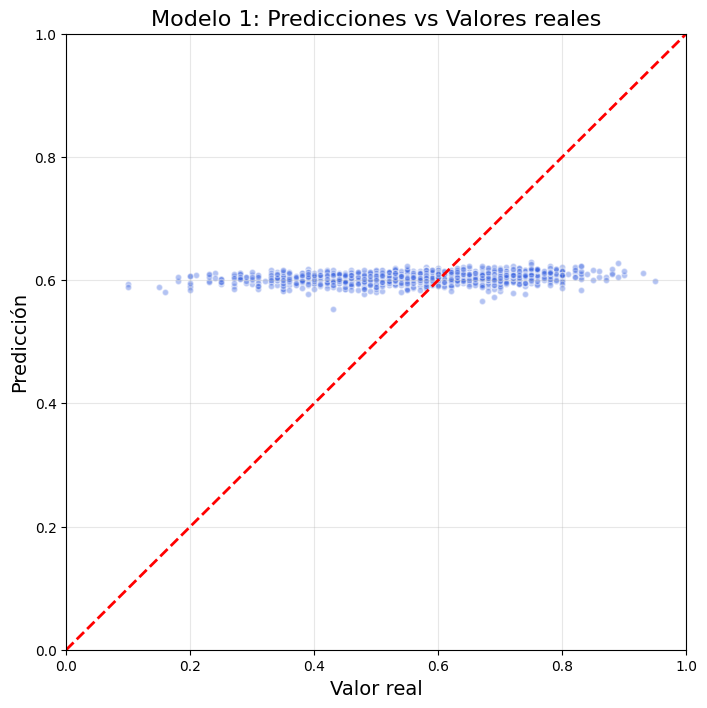

In [58]:
plt.figure(figsize=(8, 8))

plt.scatter(
    y_test_score,
    y_pred1,
    alpha=0.4,
    s=20,
    color='royalblue',
    edgecolor='white'
)

plt.plot([0, 1], [0, 1], color='red', linewidth=2, linestyle='--')

plt.title("Modelo 1: Predicciones vs Valores reales", fontsize=16)
plt.xlabel("Valor real", fontsize=14)
plt.ylabel("Predicción", fontsize=14)
plt.grid(alpha=0.3)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

Model 1 shows clear underfitting: predictions cluster around ~0.60 regardless of the true values. The model fails to follow the diagonal reference line, indicating it does not capture meaningful variation in the data. Because it uses only an embedding + global average pooling, it loses word order and long-range context, producing almost constant outputs. As a result, the model behaves like it is predicting the mean of the dataset rather than learning semantic patterns from the synopses.

### Second model

Model 2 introduces an LSTM to address the limitations of Model 1. The LSTM preserves sequence order and captures contextual dependencies that global averaging removes. This increases model capacity and enables it to extract richer semantic features from the overview text. A deeper dense layer further improves expressiveness. Overall, the changes aim to reduce underfitting and make predictions responsive to the actual content of the synopses.

Input : overview → Embedding → LSTM → Dense(64)

Dense(64) → Output (score)

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense, Concatenate, Flatten)

def getModel2(embedding_dim):
  # ---- Inputs ----
  overview_in = Input(shape=(ov_max_len,), name="overview_input")

  # ---- Overview branch (RNN) ----
  x = Embedding(ov_max_features, embedding_dim, name="embedding")(overview_in)
  x = LSTM(64, return_sequences=False, name="LSTM")(x)

  # ---- Final regressor ----
  x = Dense(64, activation='relu', name="hidden_dense64")(x)
  output = Dense(1, activation='sigmoid', name="score_output")(x)

  return Model(
      inputs=overview_in,
      outputs=output
  )

In [25]:
embedding_dim = 64

model2 = getModel2(embedding_dim)
model2.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
    ]
)
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ overview_input (InputLayer)     │ (None, 227)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 227, 64)        │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense64 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ score_output (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,249 (1.61 MB)

 Trainable params: 421,249 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model2.fit(x_train_overview, y_train_score, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - loss: 0.0219 - mae: 0.1213 - r2_score: -144.2567 - rmse: 0.1479
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 352ms/step - loss: 0.0161 - mae: 0.1022 - r2_score: -134.6133 - rmse: 0.1271
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 352ms/step - loss: 0.0102 - mae: 0.0787 - r2_score: -179.3644 - rmse: 0.1008
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - loss: 0.0059 - mae: 0.0592 - r2_score: -209.0716 - rmse: 0.0768
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - loss: 0.0040 - mae: 0.0480 - r2_score: -223.0619 - rmse: 0.0632
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - loss: 0.0023 - mae: 0.0366 - r2_score: -236.8007 - rmse: 0.0479
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - loss: 0.0015 - mae: 0.0295 - r2_score: -244.4063 - rmse: 0.0389
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - loss: 0.0011 - mae: 0.0249 - r2_score: -247.2024 - rmse: 0.0329
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/

In [27]:
loss, mae, rmse, r2 = model2.evaluate(x_test_overview, y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0304 - mae: 0.1409 - r2_score: -61.8750 - rmse: 0.1744
MSE (loss) : 0.030326364561915398
MAE : 0.13872045278549194
RMSE : 0.1741446703672409
R2 Score : -62.0205078125


In [50]:
y_pred2 = model2.predict(x_test_overview)

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Overview: Rich has decided to leave the world of crime behind for good; now he has started ...
Real rating : 0.52  – Prediction : 0.6109572
---
Overview: Alexandre, an instructor at the Canadian customs institute, finds himself under  ...
Real rating : 0.46  – Prediction : 0.59677005
---
Overview: Rémy, a former university professor and great womanizer, has cancer. His son Séb ...
Real rating : 0.72  – Prediction : 0.600466
---
Overview: The King divides his kingdom between his three daughters. Having grown old, he i ...
Real rating : 0.68  – Prediction : 0.5888893
---
Overview: It is a special, one of the few shot by Totò for TV shortly before his death, in ...
Real rating : 0.33  – Prediction : 0.6001073
---
Overview: A thief, Frankie Connor, kidnaps Barbara Blandish, the young daughter of a billi ...
Real rating : 0.55  – Prediction : 0.61005396
---
Overview: Guitarist David goes to Julia's house who asked him to give lessons to his daugh ...


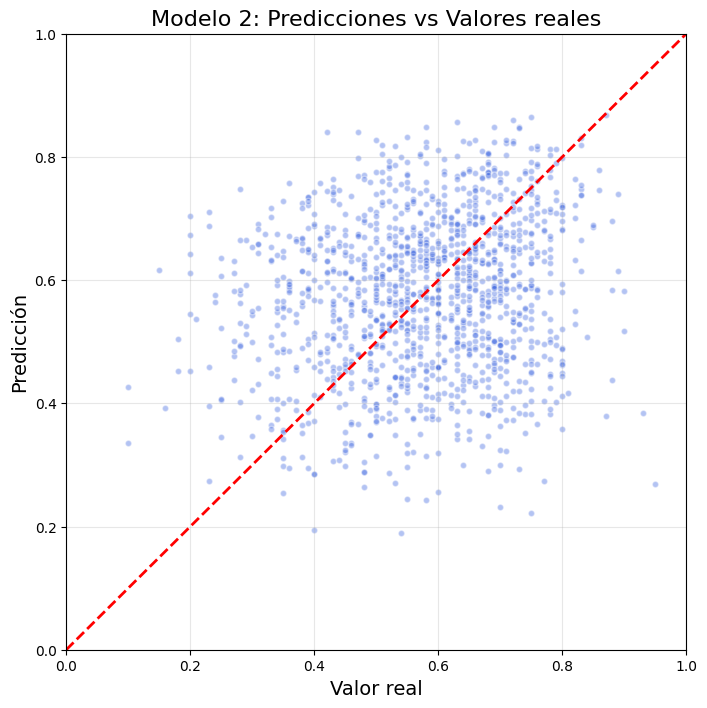

In [57]:
plt.figure(figsize=(8, 8))

plt.scatter(
    y_test_score,
    y_pred2,
    alpha=0.4,
    s=20,
    color='royalblue',
    edgecolor='white'
)

plt.plot([0, 1], [0, 1], color='red', linewidth=2, linestyle='--')

plt.title("Modelo 2: Predicciones vs Valores reales", fontsize=16)
plt.xlabel("Valor real", fontsize=14)
plt.ylabel("Predicción", fontsize=14)
plt.grid(alpha=0.3)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

Model 2 improves over Model 1 but still shows clear limitations: predictions remain overly concentrated and do not follow the diagonal trend closely. Although the LSTM captures sequential information better than averaging, using only the overview input restricts what the model can learn. The architecture underfits because essential features like title, genre, and director are ignored, limiting the richness of the representation and producing only modest gains in accuracy.

### Third model

Model 3 introduces multiple input branches to overcome the lack of information in Model 2. Adding the title, genre, and director provides complementary signals that help the model better understand a film’s context. Each branch receives its own embedding and LSTM or dense block, allowing specialized feature extraction. The final concatenation creates a richer joint representation, reducing underfitting and enabling more accurate score predictions.

Input 1 : overview → Embedding → LSTM → Dense(64)

Input 2 : title → Embedding → LSTM → Dense(16)

Input 3 : genre → Embedding → Flatten → Dense(8)

Input 4 : director → Embedding → Flatten → Dense(16)

Concatenate the 4 branches

Dense(64) → Output (score)

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense, Concatenate, Flatten)

def getModel3(embedding_dim):
  # ---- Inputs ----
  overview_in = Input(shape=(ov_max_len,), name="overview_input")
  title_in    = Input(shape=(ti_max_len,), name="title_input")
  genre_in    = Input(shape=(ge_max_len,), name="genre_input")
  director_in = Input(shape=(1,), name="director_input")

  # ---- Overview branch (RNN) ----
  x = Embedding(ov_max_features, embedding_dim, name="ov_embedding")(overview_in)
  x = LSTM(64, return_sequences=False, name="ov_LSTM")(x)
  x = Dense(64, activation='relu', name="ov_dense64")(x)

  # ---- Title embedding ----
  title_emb = Embedding(ti_max_features, output_dim=16, name="ti_embedding")(title_in)
  title_emb = LSTM(16, return_sequences=False, name="ti_LSTM")(title_emb)
  title_emb = Dense(16, activation='relu', name="ti_dense16")(title_emb)

  # ---- Genre embedding ----
  genre_emb = Embedding(ge_max_features, output_dim=8, name="ge_embedding")(genre_in)
  genre_emb = Flatten(name="ge_flatten")(genre_emb)
  genre_emb = Dense(8, activation='relu', name="ge_dense8")(genre_emb)

  # ---- Director dense ----
  director_emb = Embedding(len(le_director.classes_), output_dim=16)(director_in)
  director_emb = Flatten(name="di_flatten")(director_emb)
  director_emb = Dense(16, activation='relu', name="di_dense16")(director_emb)

  # ---- Fusion ----
  merged = Concatenate()([
      x,
      title_emb,
      genre_emb,
      director_emb
  ])

  # ---- Final regressor ----
  hidden = Dense(64, activation='relu', name="hidden_dense64")(merged)
  output = Dense(1, activation='sigmoid', name="score_output")(hidden)

  return Model(
      inputs=[overview_in, title_in, genre_in, director_in],
      outputs=output
  )

In [19]:
embedding_dim = 64

model3 = getModel3(embedding_dim)
model3.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
    ]
)
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ overview_input      │ (None, 227)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_input         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_embedding        │ (None, 227, 64)   │    384,000 │ overview_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_embedding        │ (None, 13, 16)    │     32,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_embedding        │ (None, 3, 8)      │        240 │ genre_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 16)     │     70,080 │ director_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_LSTM (LSTM)      │ (None, 64)        │     33,024 │ ov_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_LSTM (LSTM)      │ (None, 16)        │      2,112 │ ti_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_flatten          │ (None, 24)        │          0 │ ge_embedding[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_flatten          │ (None, 16)        │          0 │ embedding_1[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_dense64 (Dense)  │ (None, 64)        │      4,160 │ ov_LSTM[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_dense16 (Dense)  │ (None, 16)        │        272 │ ti_LSTM[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_dense8 (Dense)   │ (None, 8)         │        200 │ ge_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_dense16 (Dense)  │ (None, 16)        │        272 │ di_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 104)       │          0 │ ov_dense64[0][0], │
│ (Concatenate)       │                   │            │ ti_dense16[0][0], │
│                     │                   │            │ ge_dense8[0][0],  │
│                     │                   │            │ di_dense16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_dense64      │ (None, 64)        │      6,720 │ concatenate_1[0]… │
│ (Dense)             │                   │            │                 

 Total params: 533,145 (2.03 MB)

 Trainable params: 533,145 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model3.fit([x_train_overview, x_train_title, x_train_genre, x_train_director], y_train_score, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - loss: 0.0203 - mae: 0.1162 - r2_score: -70.3529 - rmse: 0.1423
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - loss: 0.0134 - mae: 0.0900 - r2_score: -77.4671 - rmse: 0.1155
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - loss: 0.0049 - mae: 0.0531 - r2_score: -110.9943 - rmse: 0.0703
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 0.0022 - mae: 0.0357 - r2_score: -117.3066 - rmse: 0.0470
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - loss: 0.0012 - mae: 0.0262 - r2_score: -122.0688 - rmse: 0.0340
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - loss: 7.5755e-04 - mae: 0.0209 - r2_score: -124.7173 - rmse: 0.0275
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - loss: 5.1925e-04 - mae: 0.0172 - r2_score: -125.7200 - rmse: 0.0228
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - loss: 4.2231e-04 - mae: 0.0153 - r2_score: -125.6410 - rmse: 0.0205
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 

With this model, we can see that the predictions already become better, and this is more noticeable for the FilmTV dataset since it is a much bigger dataset.

In [21]:
loss, mae, rmse, r2 = model3.evaluate([x_test_overview, x_test_title, x_test_genre, x_test_director], y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0195 - mae: 0.1093 - r2_score: -49.1453 - rmse: 0.1396
MSE (loss) : 0.01917446218430996
MAE : 0.10899168998003006
RMSE : 0.13847188651561737
R2 Score : -48.566165924072266


In [52]:
y_pred3 = model3.predict([x_test_overview, x_test_title, x_test_genre, x_test_director])

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Overview: Rich has decided to leave the world of crime behind for good; now he has started ...
Real rating : 0.52  – Prediction : 0.6109572
---
Overview: Alexandre, an instructor at the Canadian customs institute, finds himself under  ...
Real rating : 0.46  – Prediction : 0.59677005
---
Overview: Rémy, a former university professor and great womanizer, has cancer. His son Séb ...
Real rating : 0.72  – Prediction : 0.600466
---
Overview: The King divides his kingdom between his three daughters. Having grown old, he i ...
Real rating : 0.68  – Prediction : 0.5888893
---
Overview: It is a special, one of the few shot by Totò for TV shortly before his death, in ...
Real rating : 0.33  – Prediction : 0.6001073
---
Overview: A thief, Frankie Connor, kidnaps Barbara Blandish, the young daughter of a billi ...
Real rating : 0.55  – Prediction : 0.61005396
---
Overview: Guitarist David goes to Julia's house who asked him to give lessons to his daugh ...


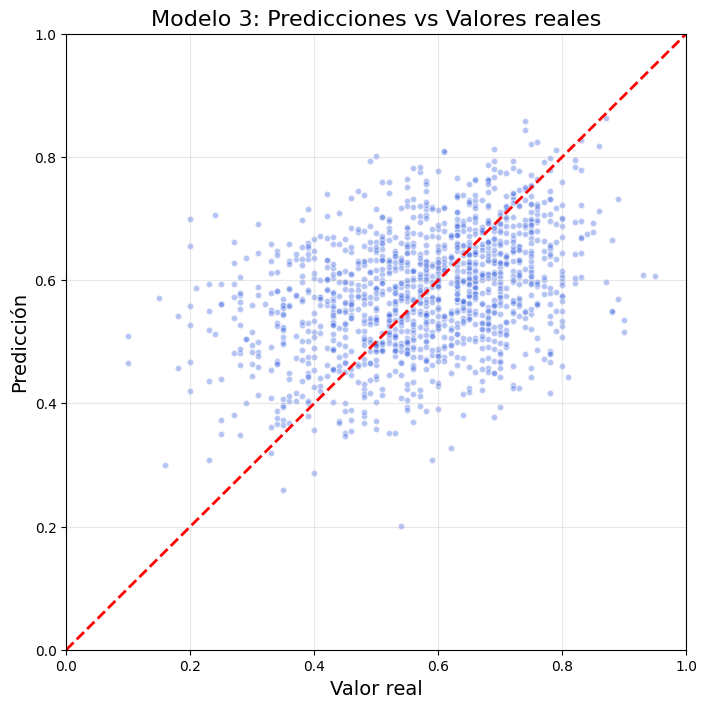

In [59]:
plt.figure(figsize=(8, 8))

plt.scatter(
    y_test_score,
    y_pred3,
    alpha=0.4,
    s=20,
    color='royalblue',
    edgecolor='white'
)

plt.plot([0, 1], [0, 1], color='red', linewidth=2, linestyle='--')

plt.title("Modelo 3: Predicciones vs Valores reales", fontsize=16)
plt.xlabel("Valor real", fontsize=14)
plt.ylabel("Predicción", fontsize=14)
plt.grid(alpha=0.3)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

Model 3 performs better than previous models thanks to its multi-branch design, integrating overview, title, genre, and director information. However, the predictions still show limited variance and tend to cluster around a central band, indicating the model is partially underfitting. The LSTM branches improve sequence understanding but the architecture lacks regularization and deeper non-linear capacity, leading to unstable learning and difficulty capturing complex interactions between inputs.

### Fourth model


Model 4 introduces three key improvements: switching LSTMs to GRUs for efficiency, adding Batch Normalization to stabilize training, and using dropout to reduce overfitting. Dense layers without bias before BN create cleaner feature distributions, making learning more effective. We also had an EarlyStopping callback for the fitting since with modifications, we will be able to train our model with more epochs. These enhancements strengthen the model’s ability to generalize, improve representation quality across branches, and allow the network to handle more complex patterns in the data.

Input 1 : overview → Embedding → GRU → Dropout 0.2 → Dense(64)

Input 2 : title → Embedding → GRU → Dropout 0.2 → Dense(16)

Input 3 : genre → Embedding → Flatten → Dense(8)

Input 4 : director → Embedding → Flatten → Dense(16)

Concatenate the 4 branches

Dense(64) → Dropout 0.3 → Output (score)

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, GRU, Dense, Concatenate,
                                    Flatten, Dropout, BatchNormalization)

def getModel4(embedding_dim):

  # ---- Inputs ----
  overview_in = Input(shape=(ov_max_len,), name="overview_input")
  title_in    = Input(shape=(ti_max_len,), name="title_input")
  genre_in    = Input(shape=(ge_max_len,), name="genre_input")
  director_in = Input(shape=(1,), name="director_input")

  # ---- Overview branch ----
  x = Embedding(ov_max_features, embedding_dim, name="ov_embedding")(overview_in)
  x = GRU(64, dropout=0.2, name="ov_GRU")(x)
  x = Dense(64, use_bias=False, name="ov_dense64")(x)
  x = BatchNormalization(name="ov_bn")(x)
  x = Dense(64, activation="gelu")(x)

  # ---- Title branch ----
  title_emb = Embedding(ti_max_features, 16, name="ti_embedding")(title_in)
  title_emb = GRU(16, dropout=0.2, name="ti_GRU")(title_emb)
  title_emb = Dense(16, use_bias=False, name="ti_dense16")(title_emb)
  title_emb = BatchNormalization(name="ti_bn")(title_emb)
  title_emb = Dense(16, activation="gelu")(title_emb)

  # ---- Genre branch ----
  genre_emb = Embedding(ge_max_features, 8, name="ge_embedding")(genre_in)
  genre_emb = Flatten(name="ge_flatten")(genre_emb)
  genre_emb = Dense(8, use_bias=False, name="ge_dense8")(genre_emb)
  genre_emb = BatchNormalization(name="ge_bn")(genre_emb)
  genre_emb = Dense(8, activation="gelu")(genre_emb)

  # ---- Director branch ----
  director_emb = Embedding(len(le_director.classes_), 16)(director_in)
  director_emb = Flatten(name="di_flatten")(director_emb)
  director_emb = Dense(16, use_bias=False, name="di_dense16")(director_emb)
  director_emb = BatchNormalization(name="di_bn")(director_emb)
  director_emb = Dense(16, activation="gelu")(director_emb)

  # ---- Fusion ----
  merged = Concatenate()([x, title_emb, genre_emb, director_emb])

  # ---- Final regressor ----
  hidden = Dense(64, use_bias=False, name="hidden_dense64")(merged)
  hidden = BatchNormalization(name="hidden_bn")(hidden)
  hidden = Dense(64, activation="gelu")(hidden)
  hidden = Dropout(0.3)(hidden)

  output = Dense(1, activation='sigmoid', name="score_output")(hidden)

  return Model(
      inputs=[overview_in, title_in, genre_in, director_in],
      outputs=output
  )


In [38]:
embedding_dim = 64

model4 = getModel4(embedding_dim)
model4.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
   ]
)
model4.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ overview_input      │ (None, 227)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_input         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_embedding        │ (None, 227, 64)   │    384,000 │ overview_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_embedding        │ (None, 13, 16)    │     32,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_embedding        │ (None, 3, 8)      │        240 │ genre_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 16)     │     70,080 │ director_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_GRU (GRU)        │ (None, 64)        │     24,960 │ ov_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_GRU (GRU)        │ (None, 16)        │      1,632 │ ti_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_flatten          │ (None, 24)        │          0 │ ge_embedding[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_flatten          │ (None, 16)        │          0 │ embedding_3[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_dense64 (Dense)  │ (None, 64)        │      4,096 │ ov_GRU[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_dense16 (Dense)  │ (None, 16)        │        256 │ ti_GRU[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_dense8 (Dense)   │ (None, 8)         │        192 │ ge_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_dense16 (Dense)  │ (None, 16)        │        256 │ di_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_bn               │ (None, 64)        │        256 │ ov_dense64[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_bn               │ (None, 16)        │         64 │ ti_dense16[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_bn               │ (None, 8)         │         32 │ ge_dense8[0][0] 

 Total params: 534,041 (2.04 MB)

 Trainable params: 533,705 (2.04 MB)

 Non-trainable params: 336 (1.31 KB)

In [39]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model4.fit([x_train_overview, x_train_title, x_train_genre, x_train_director], y_train_score, epochs=30, batch_size=64, verbose=1, callbacks=[es])

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - loss: 0.0514 - mae: 0.1816 - r2_score: -198.1753 - rmse: 0.2259
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 0.0209 - mae: 0.1146 - r2_score: -105.4446 - rmse: 0.1447
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - loss: 0.0144 - mae: 0.0937 - r2_score: -97.6624 - rmse: 0.1199
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.0106 - mae: 0.0803 - r2_score: -104.7429 - rmse: 0.1028
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - loss: 0.0077 - mae: 0.0688 - r2_score: -110.2558 - rmse: 0.0878
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 0.0060 - mae: 0.0607 - r2_score: -116.6152 - rmse: 0.0774
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - loss: 0.0047 - mae: 0.0544 - r2_score: -119.9603 - rmse: 0.0688
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - loss: 0.0040 - mae: 0.0496 - r2_score: -122.6791 - rmse: 0.0636
Epoch 9/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/s

In [40]:
loss, mae, rmse, r2 = model4.evaluate([x_test_overview, x_test_title, x_test_genre, x_test_director], y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0184 - mae: 0.1078 - r2_score: -45.5779 - rmse: 0.1358
MSE (loss) : 0.018346989527344704
MAE : 0.108070969581604
RMSE : 0.1354510635137558
R2 Score : -45.922481536865234


In [54]:
y_pred4 = model4.predict([x_test_overview, x_test_title, x_test_genre, x_test_director])

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Overview: Rich has decided to leave the world of crime behind for good; now he has started ...
Real rating : 0.52  – Prediction : 0.6109572
---
Overview: Alexandre, an instructor at the Canadian customs institute, finds himself under  ...
Real rating : 0.46  – Prediction : 0.59677005
---
Overview: Rémy, a former university professor and great womanizer, has cancer. His son Séb ...
Real rating : 0.72  – Prediction : 0.600466
---
Overview: The King divides his kingdom between his three daughters. Having grown old, he i ...
Real rating : 0.68  – Prediction : 0.5888893
---
Overview: It is a special, one of the few shot by Totò for TV shortly before his death, in ...
Real rating : 0.33  – Prediction : 0.6001073
---
Overview: A thief, Frankie Connor, kidnaps Barbara Blandish, the young daughter of a billi ...
Real rating : 0.55  – Prediction : 0.61005396
---
Overview: Guitarist David goes to Julia's house who asked him to give lessons to his daugh ...


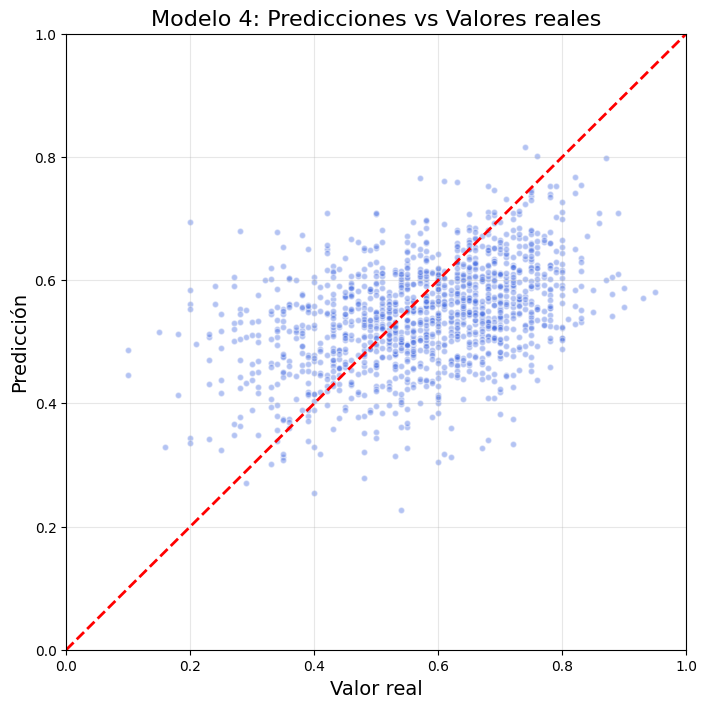

In [60]:
plt.figure(figsize=(8, 8))

plt.scatter(
    y_test_score,
    y_pred4,
    alpha=0.4,
    s=20,
    color='royalblue',
    edgecolor='white'
)

plt.plot([0, 1], [0, 1], color='red', linewidth=2, linestyle='--')

plt.title("Modelo 4: Predicciones vs Valores reales", fontsize=16)
plt.xlabel("Valor real", fontsize=14)
plt.ylabel("Predicción", fontsize=14)
plt.grid(alpha=0.3)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

Model 4 shows clear improvements thanks to GRUs, Batch Normalization, and dropout, which stabilize training and reduce overfitting. The multi-branch structure extracts richer features, producing more variable predictions than earlier models. However, the model still struggles to fully capture long-range semantic dependencies in the overview and title, since GRUs have limited capacity for long texts. As a result, performance improves but remains constrained by the recurrent architecture.

### Fifth model

Model 5 replaces GRUs with Transformers to address the limitations of recurrent networks. Transformers capture long-distance relationships and semantic structure more effectively through multi-head attention. Adding positional embeddings preserves word order, while encoder blocks deliver richer contextual representations. The mini-transformer for the title and deeper dense blocks enhance feature extraction. Overall, these changes significantly increase model expressiveness and allow better handling of complex textual information.

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Dense, Concatenate, Dropout,
                                    LayerNormalization, GlobalAveragePooling1D,
                                    Flatten, BatchNormalization, Add)
from tensorflow.keras.models import Model

# ------- Transformer Encoder Block -------
def transformer_encoder(x, head_size, num_heads, ff_dim, dropout=0.1):
  # Multi-Head Attention
  attn = tf.keras.layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout
  )(x, x)

  # Skip connection + Normalization
  x = LayerNormalization(epsilon=1e-6)(x + attn)

  # Feed Forward Network
  ffn = Dense(ff_dim, activation="gelu")(x)
  ffn = Dense(x.shape[-1])(ffn)

  # Skip + Norm
  x = LayerNormalization(epsilon=1e-6)(x + ffn)

  return x

# ------- Positional Embedding -------
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, max_len, vocab_size, embed_dim):
      super().__init__()
      self.token_emb = Embedding(vocab_size, embed_dim)
      self.pos_emb = Embedding(max_len, embed_dim)

  def call(self, x):
      maxlen = tf.shape(x)[1]
      positions = tf.range(0, maxlen, delta=1)
      positions = self.pos_emb(positions)
      x = self.token_emb(x)
      return x + positions


# ------- MODEL 5 : TRANSFORMER-BASED -------
def getModel5(embedding_dim):

  # ---- Inputs ----
  overview_in = Input(shape=(ov_max_len,), name="overview_input")
  title_in    = Input(shape=(ti_max_len,), name="title_input")
  genre_in    = Input(shape=(ge_max_len,), name="genre_input")
  director_in = Input(shape=(1,), name="director_input")

  # ---- Overview Transformer ----
  ov_emb = PositionalEmbedding(ov_max_len, ov_max_features, embedding_dim)(overview_in)
  ov_x = transformer_encoder(ov_emb, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
  ov_x = GlobalAveragePooling1D()(ov_x)
  ov_x = Dense(128, use_bias=False)(ov_x)
  ov_x = BatchNormalization()(ov_x)
  ov_x = Dense(128, activation="gelu")(ov_x)

  # ---- Title Mini-Transformer ----
  ti_emb = PositionalEmbedding(ti_max_len, ti_max_features, 32)(title_in)
  ti_x = transformer_encoder(ti_emb, head_size=16, num_heads=2, ff_dim=32, dropout=0.1)
  ti_x = GlobalAveragePooling1D()(ti_x)
  ti_x = Dense(32, use_bias=False)(ti_x)
  ti_x = BatchNormalization()(ti_x)
  ti_x = Dense(32, activation="gelu")(ti_x)

  # ---- Genre (Dense) ----
  genre_emb = Embedding(ge_max_features, 8)(genre_in)
  genre_emb = Flatten()(genre_emb)
  genre_emb = Dense(16, use_bias=False)(genre_emb)
  genre_emb = BatchNormalization()(genre_emb)
  genre_emb = Dense(16, activation="gelu")(genre_emb)

  # ---- Director (Embedding) ----
  director_emb = Embedding(len(le_director.classes_), 16)(director_in)
  director_emb = Flatten()(director_emb)
  director_emb = Dense(16, use_bias=False)(director_emb)
  director_emb = BatchNormalization()(director_emb)
  director_emb = Dense(16, activation="gelu")(director_emb)

  # ---- Fusion ----
  merged = Concatenate()([ov_x, ti_x, genre_emb, director_emb])

  # ---- Final Dense Block ----
  h = Dense(128, use_bias=False)(merged)
  h = BatchNormalization()(h)
  h = Dense(128, activation="gelu")(h)
  h = Dropout(0.3)(h)

  output = Dense(1, activation="sigmoid", name="score_output")(h)

  return Model(
      inputs=[overview_in, title_in, genre_in, director_in],
      outputs=output
  )


In [62]:
embedding_dim = 64

model5 = getModel5(embedding_dim)
model5.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
   ]
)
model5.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ overview_input      │ (None, 227)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_input         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 227, 64)   │    398,528 │ overview_input[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 13, 32)    │     64,416 │ title_input[0][0] │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 227, 64)   │     66,368 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 32)    │      4,224 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 227, 64)   │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 13, 32)    │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 227, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 32)    │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 227, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 13, 32)    │      1,056 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 227, 64)   │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 13, 32)    │      1,056 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 227, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 13, 32)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 693,393 (2.65 MB)

 Trainable params: 692,753 (2.64 MB)

 Non-trainable params: 640 (2.50 KB)

In [63]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model5.fit([x_train_overview, x_train_title, x_train_genre, x_train_director], y_train_score, epochs=15, batch_size=64, verbose=1, callbacks=[es])

Epoch 1/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - loss: 0.0387 - mae: 0.1530 - r2_score: -128.2381 - rmse: 0.1955
Epoch 2/15


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,r2_score,rmse
  current = self.get_monitor_value(logs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - loss: 0.0167 - mae: 0.1022 - r2_score: -89.5331 - rmse: 0.1291
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - loss: 0.0090 - mae: 0.0734 - r2_score: -108.2920 - rmse: 0.0949
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - loss: 0.0052 - mae: 0.0568 - r2_score: -117.2478 - rmse: 0.0724
Epoch 5/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.0035 - mae: 0.0465 - r2_score: -123.4276 - rmse: 0.0594
Epoch 6/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - loss: 0.0028 - mae: 0.0418 - r2_score: -123.1933 - rmse: 0.0529
Epoch 7/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.0025 - mae: 0.0390 - r2_score: -126.2405 - rmse: 0.0499
Epoch 8/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - loss: 0.0021 - mae: 0.0361 - r2_score: -123.7080 - rmse: 0.0456
Epoch 9/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.0020 - mae: 0.0347 - r2_score: -126.4882 - rmse: 0.0443
Epoch 10/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 0.0017 - mae: 0.

In [64]:
loss, mae, rmse, r2 = model5.evaluate([x_test_overview, x_test_title, x_test_genre, x_test_director], y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - loss: 0.0173 - mae: 0.1036 - r2_score: -41.1547 - rmse: 0.1314
MSE (loss) : 0.016637638211250305
MAE : 0.10128968209028244
RMSE : 0.12898696959018707
R2 Score : -40.56575393676758


In [65]:
y_pred = model5.predict([x_test_overview, x_test_title, x_test_genre, x_test_director])

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step
Overview: Rich has decided to leave the world of crime behind for good; now he has started ...
Real rating : 0.52  – Prediction : 0.5509902
---
Overview: Alexandre, an instructor at the Canadian customs institute, finds himself under  ...
Real rating : 0.46  – Prediction : 0.6802929
---
Overview: Rémy, a former university professor and great womanizer, has cancer. His son Séb ...
Real rating : 0.72  – Prediction : 0.6760128
---
Overview: The King divides his kingdom between his three daughters. Having grown old, he i ...
Real rating : 0.68  – Prediction : 0.5835639
---
Overview: It is a special, one of the few shot by Totò for TV shortly before his death, in ...
Real rating : 0.33  – Prediction : 0.39525467
---
Overview: A thief, Frankie Connor, kidnaps Barbara Blandish, the young daughter of a billi ...
Real rating : 0.55  – Prediction : 0.67990965
---
Overview: Guitarist David goes to Julia's house who asked him to give lessons to his daugh .

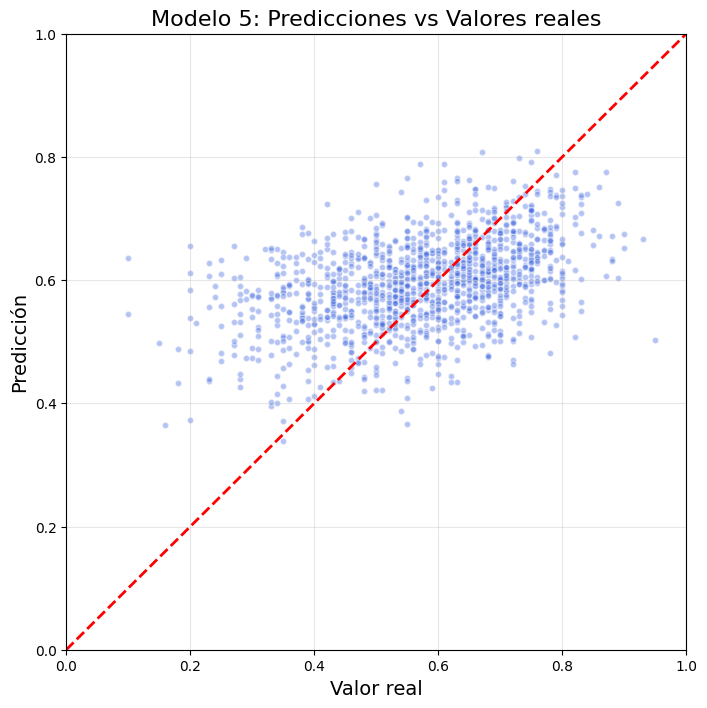

In [66]:
plt.figure(figsize=(8, 8))

plt.scatter(
    y_test_score,
    y_pred,
    alpha=0.4,
    s=20,
    color='royalblue',
    edgecolor='white'
)

plt.plot([0, 1], [0, 1], color='red', linewidth=2, linestyle='--')

plt.title("Modelo 5: Predicciones vs Valores reales", fontsize=16)
plt.xlabel("Valor real", fontsize=14)
plt.ylabel("Predicción", fontsize=14)
plt.grid(alpha=0.3)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()